# Ifremer Product 1 Global Characteristic of SWH and WSP Seasonal cycle Least Square Fit Model with a 5 Parameter Fit 

Plot figure within jupyter notebook

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [3]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
import datetime
#plotting libraries
import cmocean.cm as cmo
from matplotlib import cm 
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib
from numpy import pi


#my functions
from unweighted_least_square_fit import least_square_fit 
from char_LSF_curve import character_LSF
from monthly_mean import monthly_average
import cartopy_fig_module as cart

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the Ifremer data set, we want the following data orientation: 

In [4]:
nt, nlon, nlat = 8400, 360, 133
initial_year = 1993
final_year = 2015
initial_mon = 1
final_mon = 12

Set filename and look at key variables and attributes

In [5]:
#Bia's binned data: 
#filename = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/bia_daily_binned_ifremer_data/all_sat_binned_swh_1992-08-23_2016-08-23.nc'
#My binned data: 
filename_swh = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/ifremer_swh_daily_binned_data_93_16_bia.nc'
filename_wsp = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/ifremer_wsp_daily_binned_data_93_16_bia.nc'

#set nc variable in order to read attributes and obtained data: 
#bia's data:
#nc = Dataset(filename, 'r')
#My data
nc_swh =  Dataset(filename_swh, 'r')
nc_wsp =  Dataset(filename_wsp, 'r')

#print key variables:
print(nc_swh.variables.keys())

#longitude
for at in nc_swh.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['lon'].getncattr(at)))

#laitude
for at in nc_swh.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['lat'].getncattr(at)))
    
#time 
for at in nc_swh.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['time'].getncattr(at)))

odict_keys(['time', 'lon', 'lat', 'swh'])
units : degrees east
units : degrees north
units : days since 1900-01-01 00:00:00
calendar : julian


Call Ifremer Product 1 daily binned data from the server

In [6]:
swh = nc_swh.variables['swh'][:]
wsp = nc_wsp.variables['wsp'][:]
lon = nc_swh.variables['lon'][:]
lat = nc_swh.variables['lat'][:]
time_i = num2date(nc_swh.variables['time'][:], nc_swh.variables['time'].units) #convert time directly into datetime format instead of integer value time 

Restrict the latitude dimesnion of the swh and wsp data sets 

In [7]:
swh = swh[:,24:157,:]
wsp = wsp[:,24:157,:]
lat = lat[24:157]
print(lat.shape, swh.shape)

(133,) (8766, 133, 360)


Check to see if swh and wsp are masked arrays

In [8]:
print(swh.shape,time_i.shape)

(8766, 133, 360) (8766,)


Restrict the time series from 1993 to 2015 for swh_cor 

In [9]:
#find initial and final indices: 
#create year vector: 
years = np.array([y.year for y in time_i])

#creat boolean arrays and combine them: 
#ind_92 = years != 1992
ind_16 = years != 2016
#ind_time = ind_92*ind_16
ind_time = ind_16

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matirx along the time axis from swh
swh_c = np.compress(ind_time, swh, axis = 0)
wsp_c = np.compress(ind_time, wsp, axis = 0)
print(swh_c.shape,wsp_c.shape)

#extract the time steps: 
time_c = time_i[ind_time]


(8400, 133, 360) (8400, 133, 360)


Calculate the monthly averaged swh and wsp from 1993 to 2015

In [10]:
swh_month_data = monthly_average(date_time = time_c, data = swh_c, fill_val = 'mask')
wsp_month_data = monthly_average(date_time = time_c, data = wsp_c, fill_val = 'mask')

Save mean, meadian, standard deviation, and number of observations (will be later used to calculate the standard deviation of the mean) in separate np.array variables. Change each dictionary key from a list to a np.array:

In [11]:
#For swh:
swh_monthly_mean = np.ma.array(swh_month_data['mean'])
swh_monthly_median = np.ma.array(swh_month_data['median'])
swh_monthly_std = np.ma.array(swh_month_data['std'])
swh_monthly_n = np.ma.array(swh_month_data['N'])

#For wsp:
wsp_monthly_mean = np.ma.array(wsp_month_data['mean'])
wsp_monthly_median = np.ma.array(wsp_month_data['median'])
wsp_monthly_std = np.ma.array(wsp_month_data['std'])
wsp_monthly_n = np.ma.array(wsp_month_data['N'])

In [12]:
def least_square_fit(data, trend, parameters, period, fill_val):
    
    """
    least_square_fit(data, trend, parameters, period, fill_val)
    
        Function to compute the unweighted least square fit of temporal data 
        
        Parameters 
        ----------
        data : numpy 2D array of temporal data
               e.g. print(data.shape) => (133,) 
        trend : type of function least square is fitting. Options for this variables include: 
               a) trend = 'linear'
               b) trend = 'exponential'
               c) trend = 'sinusoidal' 
        parameters : number of parameters in model 
               a) if trend = 'linear', then options for parameters includes: 
                    i) parameters = 1 : fits mean 
                    ii) parameters = 2 : fits mean and linear trend 
               b) if trend = 'exponential', then the only option for paramters includes: 
                    i) parameters = 2: fits linear trend and mean offset to a linearized exponential equation 
               c) if trend = 'sinusiodal', then options for paramters includes: 
                    i) parameters = 3 : fits mean, and annual cycle (period = 1 year, 12 months, or 365.25 days)
                    ii) parameters = 4 : fits mean, linear trend, and annual cycle
                    iii) parameters = 5 : fits mean, annual cycle, and semi-annual cycle (period= 1/2 year,6 months,182.625 days)
                    iv) paramters = 6: fits mean, linear trend, annual cycle, and semi-annual cycle 

        period : period of the frequency of the sinusoidal signal 
        
        fill_val : determines what fill value is present in your data set. Options include:
               fill_val = 'NaN' or fill_val = 'mask' or fill_val = 'none'
        
        Returns
        -------
        data_ulsf : unweighted least square fitted data
        
        Libraries necessary to run function
        -----------------------------------
        Numpy : import numpy as np
        
    """
    
    #import libraries: 
    import numpy as np
    from scipy.linalg import inv
    
    #consider for LSF only unmasked or non-nan data: 
    if fill_val == 'mask':
        ind = data.mask
    elif fill_val == 'NaN':
        ind = np.isnan(data)
        
    #set all masked data points to the mean swh of the time series or interpolate the data: 
    if fill_val == 'mask':
        data[ind] = np.ma.mean(data)
    elif fill_val == 'NaN':
        data[ind] = np.nanmean(data)
        
    #initialize time vector: 
    time = np.arange(1,len(data)+1,1)
    
    #set number of parameters and length of data: 
    N, M = parameters, len(data)

    #create model matrix: 
    A = np.zeros((M,N))
    
    #set conditional statements for each case that the lsf will be applied: 
    if trend == 'linear':
        
        #set the two cases for the linear trend parameters: 
        if parameters == 1: 
            #place parameters in model matrix: 
            A[:,0] = 1.0
            #Compute solution to the matrix equation Ax = b:  
            x_data = np.dot( np.dot( inv(np.dot(A.conj().T, A)), A.conj().T), data.conj().T)
            #Compute unweighted least square fit model: 
            hfit = x_data[0]
            
        elif parameters == 2: 
            #place parameters in model matrix: 
            A[:,0] = 1.0
            A[:,1] = time
            #Compute solution to the matrix equation Ax = b:  
            x_data = np.dot( np.dot( inv(np.dot(A.conj().T, A)), A.conj().T), data.conj().T)
            #Compute unweighted least square fit model: 
            hfit = x_data[0] + x_data[1]*time
    
    elif trend == 'exponential':
        
        #set the two cases for the linear trend parameters: 
        if parameters == 2: 
            #place parameters in model matrix: 
            A[:,0] = 1.0
            A[:,1] = time
            #Compute solution to the matrix equation Ax = b:  
            x_data = np.dot( np.dot( inv(np.dot(A.conj().T, A)), A.conj().T), data.conj().T)
            #Compute unweighted least square fit model: 
            hfit = x_data[0] + x_data[1]*time
        
    elif trend == 'sinusoidal':
        
        #set the two cases for the linear trend parameters: 
        if parameters == 3: 
            #place parameters in model matrix: 
            A[:,0] = 1.0
            A[:,1] = np.sin(time*2*np.pi/period)
            A[:,2] = np.cos(time*2*np.pi/period)
            #Compute solution to the matrix equation Ax = b:  
            x_data = np.dot( np.dot( inv(np.dot(A.conj().T, A)), A.conj().T), data.conj().T)
            #Compute unweighted least square fit model: 
            hfit = x_data[0] + x_data[1]*np.sin(time*2*np.pi/period) + x_data[2]*np.cos(time*2*np.pi/period)
            
        elif parameters == 4: 
            #place parameters in model matrix: 
            A[:,0] = 1.0
            A[:,1] = time
            A[:,2] = np.sin(time*2*np.pi/period)
            A[:,3] = np.cos(time*2*np.pi/period)
            #Compute solution to the matrix equation Ax = b:  
            x_data = np.dot( np.dot( inv(np.dot(A.conj().T, A)), A.conj().T), data.conj().T)
            #Compute unweighted least square fit model: 
            hfit = x_data[0] + x_data[1]*time + x_data[2]*np.sin(time*2*np.pi/period) + x_data[3]*np.cos(time*2*np.pi/period)
            
        elif parameters == 5:
            #place parameters in model matrix: 
            A[:,0] = 1.0
            A[:,1] = np.sin(time*2*np.pi/period)
            A[:,2] = np.cos(time*2*np.pi/period)
            A[:,3] = np.sin(time*2*np.pi/(period/2))
            A[:,4] = np.cos(time*2*np.pi/(period/2))
            #Compute solution to the matrix equation Ax = b:  
            x_data = np.dot( np.dot( inv(np.dot(A.conj().T, A)), A.conj().T), data.conj().T)
            #Compute unweighted least square fit model: 
            hfit = x_data[0] + x_data[1]*np.sin(time*2*np.pi/period) + x_data[2]*np.cos(time*2*np.pi/period) + x_data[3]*np.sin(time*2*np.pi/(period/2)) + x_data[4]*np.cos(time*2*np.pi/(period/2))
            
        elif parameters == 6: 
            #place parameters in model matrix: 
            A[:,0] = 1.0
            A[:,1] = time
            A[:,2] = np.sin(time*2*np.pi/period)
            A[:,3] = np.cos(time*2*np.pi/period)
            A[:,4] = np.sin(time*2*np.pi/(period/2))
            A[:,5] = np.cos(time*2*np.pi/(period/2))
            #Compute solution to the matrix equation Ax = b:  
            x_data = np.dot( np.dot( inv(np.dot(A.conj().T, A)), A.conj().T), data.conj().T)
            #Compute unweighted least square fit model: 
            hfit = x_data[0] + x_data[1]*time + x_data[2]*np.sin(time*2*np.pi/period) + x_data[3]*np.cos(time*2*np.pi/period) + x_data[4]*np.sin(time*2*np.pi/(period/2)) + x_data[5]*np.cos(time*2*np.pi/(period/2))
            
            
    return hfit, x_data

Create a loop to go through each grid point and compute the unweighted least square fit and the characteristics of the fit (e.g. residual, amplitude, phase constant, and coefficient of determination) 

In [13]:
#initialize masked arrays to save data in: 
swh_hfit_m = np.ma.masked_all([swh_monthly_mean.shape[0], nlat, nlon])
swh_rms_m = np.ma.masked_all([nlat, nlon])
swh_amp1_m = np.ma.masked_all([nlat, nlon])
swh_phase1_m = np.ma.masked_all([nlat, nlon])
swh_amp2_m = np.ma.masked_all([nlat, nlon])
swh_phase2_m = np.ma.masked_all([nlat, nlon])
swh_cod_m = np.ma.masked_all([nlat, nlon])
#wsp_hfit_m = np.ma.masked_all([wsp_monthly_mean.shape[0], nlat, nlon])
wsp_rms_m = np.ma.masked_all([nlat, nlon])
wsp_amp1_m = np.ma.masked_all([nlat, nlon])
wsp_phase1_m = np.ma.masked_all([nlat, nlon])
wsp_amp2_m = np.ma.masked_all([nlat, nlon])
wsp_phase2_m = np.ma.masked_all([nlat, nlon])
wsp_cod_m = np.ma.masked_all([nlat, nlon])

for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        
        #call data in monthly mean matrix for swh and wsp: 
        swh_grid = swh_monthly_mean[:,ilat,ilon]
        #swh_grid = swh_c[:,ilat,ilon]
        wsp_grid = wsp_monthly_mean[:,ilat,ilon]
        #wsp_grid = wsp_c[:,ilat,ilon]
        
        #place a conditional statement for swh that will ignore all time series that have less than 200 data points in the time series 
        #find non-masked values: 
        ival_swh = np.ma.nonzero(swh_grid)
        iswh = len(swh_grid[ival_swh])
        print(iswh)
        #place condition:
        if iswh > 46: 
            
            #detrend linear trend at grid point: 
            swh_trend, x_trend = least_square_fit(data = swh_grid, trend = 'linear', parameters = 2, 
                                                    period = 12, fill_val = 'mask')
            #remove linear trend: 
            swh_detrend = swh_grid-swh_trend
            
            #compute least square fit:
            swh_hfit, x_swh = least_square_fit(data = swh_detrend, trend = 'sinusoidal', parameters = 5, 
                                               period = 12, fill_val = 'mask')
            #compute characteristics of least square fit
            swh_rms, swh_amp1, swh_phase1, swh_amp2, swh_phase2, swh_cod = character_LSF(data = swh_detrend, 
                                                                                         model = swh_hfit, 
                                                                                         x_solution = x_swh, 
                                                                                         trend = 'sinusoidal', 
                                                                                         parameters = 5, 
                                                                                         fill_val = 'mask')
            #save each data into a 2D array:
            #For swh:
            swh_hfit_m[:,ilat,ilon] = swh_hfit
            swh_rms_m[ilat,ilon] = swh_rms
            swh_amp1_m[ilat,ilon] = swh_amp1
            swh_phase1_m[ilat,ilon] = swh_phase1
            swh_amp2_m[ilat,ilon] = swh_amp2
            swh_phase2_m[ilat,ilon] = swh_phase2
            swh_cod_m[ilat,ilon] = swh_cod
            
        #place a conditional statement for swh that will ignore all time series that have less than 200 data points in the time series 
        #find non-nan values: 
        ival_wsp = np.ma.nonzero(wsp_grid)
        iwsp = len(wsp_grid[ival_wsp])
        print(iwsp)
        #plcae condition:
        if iwsp > 46:    
            #detrend grid point: 
            wsp_trend, x_trend = least_square_fit(data = wsp_grid, trend = 'linear', parameters = 2, 
                                                  period = 12, fill_val = 'mask')
            #remove linear trend: 
            wsp_detrend = wsp_grid-wsp_trend
            
            #compute least square fit:
            wsp_hfit, x_wsp = least_square_fit(data = wsp_detrend, trend = 'sinusoidal', 
                                               parameters = 5, period = 12, fill_val = 'mask')
            #compute characteristics of least square fit
            wsp_rms, wsp_amp1, wsp_phase1, wsp_amp2, wsp_phase2, wsp_cod = character_LSF(data = wsp_detrend, 
                                                                                         model = wsp_hfit, 
                                                                                         x_solution = x_wsp, 
                                                                                         trend = 'sinusoidal', 
                                                                                         parameters = 5, 
                                                                                         fill_val = 'mask')
            #save each data into a 2D array:
            #For wsp:
            #wsp_hfit_m[:,ilat,ilon] = wsp_hfit
            wsp_rms_m[ilat,ilon] = wsp_rms
            wsp_amp1_m[ilat,ilon] = wsp_amp1
            wsp_phase1_m[ilat,ilon] = wsp_phase1
            wsp_amp2_m[ilat,ilon] = wsp_amp2
            wsp_phase2_m[ilat,ilon] = wsp_phase2
            wsp_cod_m[ilat,ilon] = wsp_cod
        

133
132
134
134
134
133
133
132
135
135
139
139
139
139
139
139
140
140
133
133
133
133
128
128
129
128
132
131
130
130
130
130
131
130
131
130
131
129
132
130
132
132
131
130
132
131
132
132
133
132
132
132
133
133
132
132
131
131
131
131
133
133
132
131
132
132
129
129
134
134
137
137
149
149
155
154
157
156
157
157
157
157
153
153
153
153
152
152
146
145
137
137
132
131
126
125
120
120
113
113
108
107
89
88
87
87
77
76
86
84
78
75
78
75
90
90
93
93
93
93
97
96
96
95
94
94
91
91
90
90
90
90
88
87
87
87
86
85
85
85
88
87
89
88
87
87
88
87
89
88
87
87
83
83
81
80
79
79
71
71
63
61
53
53
49
49
53
50
56
55
57
56
68
68
84
82
96
94
118
117
56
56
86
85
96
94
106
106
115
115
139
138
21
21
0
0
71
71
28
27
8
6
0
0
31
30
82
83
0
0
44
43
96
96
55
55
73
73
71
71
79
77
43
43
55
53
37
32
39
34
32
32
19
19
15
15
34
34
52
49
90
89
95
94
103
102
58
57
37
36
27
27
30
30
28
28
37
35
44
43
66
66
126
124
89
89
92
91
101
99
98
98
93
92
61
61
76
76
87
86
87
87
93
93
100
98
100
100
99
98
98
97
96
93
80
80
72

147
147
144
144
142
142
144
144
148
148
144
143
147
147
148
147
152
151
149
148
151
148
147
147
149
149
148
148
146
146
142
141
131
131
133
133
137
137
144
144
149
147
154
153
152
152
149
149
150
150
145
145
147
145
145
144
150
150
151
149
157
152
160
159
164
162
173
169
173
172
173
172
181
180
177
173
171
165
171
169
172
169
184
182
189
187
193
188
192
191
196
194
205
198
207
202
205
202
214
210
217
214
223
222
221
221
227
224
238
236
244
241
247
242
250
246
258
255
264
261
265
264
270
267
271
270
271
271
266
266
266
261
262
258
260
259
256
253
251
248
248
246
249
248
253
252
261
260
261
260
264
263
255
253
251
249
247
246
254
252
248
243
243
242
239
236
224
223
215
215
212
208
211
210
207
205
207
206
202
200
199
194
195
190
195
191
202
199
207
204
216
212
217
212
230
227
240
238
247
245
252
250
248
245
256
254
267
266
270
270
274
274
276
276
276
276
276
276
276
275
276
276
276
276
274
274
274
274
275
274
274
274
274
273
274
273
274
274
272
271
270
268
269
268
266
266
265
265
257
255


179
178
183
182
185
184
194
192
199
197
205
204
205
203
218
217
222
221
224
224
231
230
230
226
235
233
236
235
226
223
231
230
245
241
242
237
243
239
246
245
239
238
243
243
248
248
248
246
252
251
251
251
248
243
248
247
247
245
247
243
253
251
253
247
250
246
251
250
246
240
246
244
251
250
244
243
242
239
247
247
238
237
243
242
246
244
245
239
253
250
247
244
249
244
254
252
249
246
242
238
246
245
245
243
239
235
236
236
223
220
211
210
210
208
203
200
202
202
206
205
202
199
202
202
200
198
204
200
211
210
210
209
211
206
226
222
247
240
267
265
271
269
271
269
269
267
267
266
265
264
268
267
269
269
267
265
268
268
267
266
265
262
264
263
262
260
263
262
267
267
268
268
270
269
272
272
273
273
274
274
276
276
274
274
275
275
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


215
210
220
219
208
205
211
209
211
210
201
197
205
201
210
206
225
223
229
227
234
231
230
227
232
230
226
222
220
218
209
203
213
212
215
214
208
205
220
217
222
222
224
224
226
225
229
227
233
230
237
234
235
233
234
234
234
234
233
233
235
235
238
238
249
248
263
263
267
267
268
267
272
272
275
275
275
274
275
275
275
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
276
275
276
276
276
274
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
273
274
274
274
274
273
271
275
274
274
273
273
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
275
276
276
274
274
275
275
275
275
276
276
276
276
276
276
276
276
276
276
275
275
276
276
274
274
275
275
274
274
274
273
273
272
273
272
273
273
274
274
273
272
274
274
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
274
276
276
276
276
276
276
276
275
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


275
273
242
276
276
276
276
276
245
276
276
276
276
273
241
276
276
276
276
276
276
276
276
276
275
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
273
241
276
276
276
276
276
244
276
276
276
276
273
242
276
276
276
276
276
275
261
228
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
275
276
276
276
275
276
276
276
276
276
276
276
276
276
276
273
243
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
243
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
244
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
275
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
272
241
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
250
276
276
276
276
273
242
276
276
276
276
275
245
276
276
276
276
276
264
276
276
276
276
276
276
273
243
276
276
276
276
276
246
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
273
241
276
276
276
276
276
275
276
276
276
275
276
276
276
276
276
276
276
276
276
276
272
242
276
276
276
276
276
246
276
276
276
276
273
243
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
247
276
276
276
276
276
245
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
262
276


273
242
276
276
276
245
276
276
276
276
276
244
276
276
276
276
273
242
276
276
276
276
276
245
264
261
271
271
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
243
276
276
276
276
273
241
276
276
276
276
276
246
276
276
276
276
276
245
276
276
276
276
273
242
276
276
276
245
276
276
276
276
276
245
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
246
276
276
276
276
276
245
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
273
243
276
276
273
242
276
276
276
276
276
246
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


275
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
274
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
275
276
276
276
276
276
275
276
276
256
256
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
274
276
276
276
276
276
274
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
276
241
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276


276
276
243
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
246
276
275
276
276
273
243
276
276
276
276
273
243
276
276
276
276
273
241
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
244
274
272
276
276
273
240
252
217
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
267
233
276
276
276
276
276
246
276
276
276
276
273
242
276
276
276
276
273
241
276
276
276
276
276
245
276
276
273
240
273
244
276
276
273
242
276
276
276
276
276
246
276
276
276
276
273
241
276
276
276
276
272
241
276
276
276
276
276
245
276
276
273
242
273
241
276
276
273
242
276
276
276
276
276
244
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
273
242
276
276
273
242
273
241
276
276
273
243
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
245
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
271
238
276
276
276
276
273
241
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
246
276
276
276
276
273
242
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
161
159
275
275
276
276
276
276
276
246
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
246
276
276
276
276
273
241
276
276
276
276
273
243
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
243
276
276
276
276
273
243
276
275
276
276
273
243
276
276
276
275
276
265
276
276
276


240
276
276
276
276
276
244
276
276
276
276
276
244
276
276
276
276
272
242
276
276
276
275
275
245
276
276
276
276
276
246
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
275
276
276
271
239
276
276
273
241
276
276
276
276
276
246
276
276
276
276
276
246
276
276
276
276
273
242
276
276
276
276
273
241
276
276
276
276
273
241
276
276
273
241
276
276
276
276
276
244
276
276
276
276
273
241
276
276
276
276
273
239
276
276
276
276
273
241
276
276
276
276
273
242
276
276
273
239
276
276
276
276
276
245
276
275
276
276
272
240
276
276
276
276
273
242
276
276
276
276
273
240
276
276
276
276
273
241
276
276
273
240
276
276
276
276
273
243
276
276
276
276
273
240
276
276
276
276
273
240
276
276
276
276
273
242
276
276
276
276
273
242
276
276
272
241
276
276
276
276
273
241
276
276
276
276
273
241
276
276
276
276
273
240
276
276
276
276
272
237
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


244
276
276
273
242
273
242
276
276
276
244
274
258
276
276
273
242
276
276
276
276
273
242
276
276
276
276
273
240
276
276
276
276
276
245
276
276
273
243
273
242
276
276
276
245
268
232
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
209
176
276
276
276
276
273
243
276
276
276
274
276
245
276
276
273
243
273
242
276
276
273
242
273
242
276
276
276
245
276
276
276
276
273
241
276
276
276
276
273
241
276
276
276
276
273
243
276
276
273
242
276
245
276
276
273
242
273
243
276
276
276
246
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
273
242
276
276
273
241
276
244
276
276
273
242
273
242
276
276
276
245
276
276
276
276
276
244
276
276
276
276
273
242
276
276
276
276
273
242
276
276
273
242
276
245
276
276
273
242
273
242
276
276
273
243
276
276
276
276
276
244
276
276
276
276
273
242
276
276
276
276
273
242
276
276
273
243
275
243
276
276
273
242
272
242
276
276
273


276
276
273
242
276
276
276
275
273
240
276
276
272
240
273
241
276
276
273
243
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
273
241
276
276
276
276
273
241
276
276
273
242
273
243
276
276
273
241
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
276
276
245
276
276
273
243
273
242
276
276
273
243
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
276
246
276
276
273
239
273
241
276
276
273
242
276
275
276
276
273
241
276
276
276
276
273
241
276
276
276
276
276
245
276
276
276
276
276
243
276
276
273
242
273
241
276
276
273
242
276
257
276
276
276
245
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
276
245
276
276
273
243
273
241
276
276
276
245
276
244
276
276
276
245
276
276
276
276
273
243
276
276
276
276
276
245
276
276
276
276
276
245
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
252
210
276
276
276
276
273
243
276
276
276


276
276
276
276
244
276
276
276
275
273
240
276
276
272
241
272
240
276
276
275
244
276
276
276
276
273
242
276
276
276
276
272
242
276
276
276
276
274
244
276
276
276
276
273
243
276
276
272
242
272
239
276
276
276
245
276
276
276
276
273
242
276
276
276
276
260
228
276
276
276
276
273
243
276
276
276
276
273
241
276
276
276
276
276
276
276
276
273
242
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
273
242
276
276
276
276
272
240
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
276
276
276
276
275
244
276
276
276
276
273
242
276
276
276
275
273
241
276
276
276
276
276
276
276
276
273
242
276
276
276
276
272
240
276
276
276
276
275
244
276
276
276
276
271
240
276
276
276
275
273
241
276
276
276
276
276
275
276
276
273
241
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
273
242
276
276
276
276
271
239
276
276
276
276
276
275
276
276
273
241
276
276
276
276
272
241
276
276
276
276
276
244
276
276
276
276


276
276
273
241
276
276
276
276
272
241
276
276
276
276
273
242
276
276
272
241
276
245
276
276
273
243
273
242
276
276
200
157
116
86
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
116
71
276
276
264
229
266
229
0
0
0
0
0
0
0
0
272
236
276
276
276
276
273
241
276
276
275
258
275
244
276
276
273
243
273
242
276
276
272
240
276
276
276
276
276
246
276
276
276
276
273
239
276
276
276
276
273
241
276
276
276
245
276
245
276
276
273
241
273
241
276
276
273
243
276
276
276
276
276
245
276
276
276
276
272
239
276
276
276
276
273
243
276
276
276
276
276
246
276
276
273
242
273
242
276
276
273
241
276
275
276
276
276
245
276
276
276
276
273
242
276
276
276
276
272
241
276
276
276
276
275
244
276
276
273
242
273
242
276
276
273
241
276
275
276
276
275
245
276
276
276
276
273
241
276
276
276
276
272
241
276
276
276
276
276
246
276
276
273
241
273
242
276
276
272
241
274
269
276
276
276
245
276
276
276
276
272
241
276
276
276
276
273
243
276
276
276
275
273
241
276
276
273
241
273
241
276
27

241
276
269
276
276
276
245
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
273
242
276
276
273
243
276
258
276
276
276
246
276
276
276
276
273
241
276
276
276
276
272
241
276
276
276
276
273
243
276
276
276
276
272
242
276
276
273
243
273
247
276
276
275
244
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
276
272
242
276
276
276
276
273
243
276
276
273
242
273
243
276
276
274
243
276
276
276
276
273
241
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
273
242
276
276
273
242
268
235
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
273
242
276
276
273
242
276
246
276
276
276
245
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
273
243
276
276
273
243
276
245
276
276
276
246
276
276
276
276
273
242
276


276
276
276
275
273
242
276
276
276
276
272
240
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
246
276
276
276
275
273
241
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
274
276
275
276
276
273
242
273
240
276
276
276
245
276
276
276
276
272
241
276
276
276
276
273
243
276
276
276
276
272
242
9
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
177
174
31
8
0
0
0
0
0
0
0
0
271
267
275
245
276
276
276
276
273
241
276
276
276
276
273
243
276
276
273
241
276
246
276
276
273
241
273
241
276
276
273
242
276
276
276
276
276
245
276
276
276
276
273
240
276
276
276
276
273
242
276
276
276
245
274
244
276
276
271
241
275
242
276
276
269
238
276
276
276
276
276
245
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
245
273
240
276
276
273
240
276
246
276
276
273
242
276
276
276
276
276
246
276
276
276
276
272
239
276
276
276
275
273
241
276
276
275
245
273
243
276
276
273
241
276
244
276
276
273
242
276
275
276

276
276
275
276
276
276
276
276
275
276
276
276
276
272
241
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
246
276
276
276
276
273
243
276
276
276
276
276
243
276
276
57
26
0
0
276
276
263
225
101
72
276
276
269
236
276
274
276
276
274
240
276
276
276
276
272
239
276
276
276
276
276
241
276
275
276
275
275
241
276
276
276
275
276
274
276
276
276
275
273
257
276
276
276
245
276
276
276
276
272
241
276
276
276
276
42
27
0
0
0
0
0
0
0
0
0
0
0
0
0
0
185
141
276
276
276
276
275
240
276
276
276
276
273
240
276
276
276
276
271
239
276
275
276
275
271
240
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
275
276
276
273
243
276
276
276
276
273
240
276
276
276
276
273
243
276
276
276
276
276
276
276
276
276
275
276
276
276
276
271
240
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
273
243
2

276
276
276
276
244
276
276
276
275
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
275
276
276
276
276
276
276
276
275
276
276
276
258
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
274
276
276
276
276
276
276
276
276
276
276
276
276
276
274
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
264
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
250
207
276
276
276
276
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


241
276
275
276
276
274
242
276
276
276
276
273
241
276
276
276
276
272
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
272
242
276
276
276
276
273
241
276
276
276
276
273
242
276
276
276
276
272
241
276
276
276
276
276
276
271
239
276
276
276
276
276
276
276
276
276
276
276
276
275
275
276
276
276
276
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
1
29
7
0
0
95
63
274
273
82
49
3
3
0
0
0
0
0
0
0
0
0
0
0
0
14
10
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
272
240
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
275
276
276
276
275
276
276
276
276
272
269
273
273
0
0
0
0
13
12
273
271
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0

276
276
274
243
275
262
254
250
74
42
276
276
272
269
115
84
13
3
276
276
274
240
276
276
276
276
272
239
276
276
276
276
276
275
276
276
267
244
0
0
0
0
0
0
0
0
273
271
268
235
276
275
276
276
275
242
275
275
276
276
270
236
276
276
276
276
276
276
276
276
276
274
276
275
276
276
272
240
276
276
276
276
271
238
276
276
276
276
276
244
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
243
276
276
276
276
273
241
276
276
276
276
276
245
276
276
276
276
272
241
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
273
243
276
276
276
276
276
245
276
276
276
275
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
271
240
276
276
276
276
276
245
276
276
276
276
272
240
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
273
242
276
276
276
276
275
243
276
276
276
276
271
241
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
273
241
276
27

276
276
244
273
242
276
276
273
241
276
276
276
276
276
245
276
276
276
276
276
246
276
276
273
241
273
242
276
276
276
246
273
242
276
276
276
244
272
240
276
276
273
242
276
276
276
276
276
245
276
276
276
276
273
240
276
276
273
240
273
242
276
276
276
246
273
243
276
276
276
246
273
242
276
276
273
243
276
276
276
276
276
245
276
276
276
276
273
241
276
276
273
241
273
242
276
276
276
245
273
242
276
276
276
244
272
241
276
276
273
241
276
276
276
276
273
241
276
276
276
276
272
242
276
276
273
241
273
242
276
276
276
245
273
241
276
276
273
242
273
241
276
276
273
243
276
276
276
276
273
242
276
276
276
276
273
240
276
276
273
241
273
242
276
276
273
243
273
241
276
276
273
241
273
242
276
276
273
241
276
276
276
276
273
242
89
51
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
11
3
276
276
276
268
273
240
276
276
273
241
276
244
276
276
273
242
273
242
276
276
273
242
276
276
276
276
273
242
276
276
276
276
273
240
276
276
276
273
276
245
276
276
273
243
2

276
276
276
276
276
273
239
276
274
276
276
273
242
276
275
276
276
276
245
276
276
276
276
271
238
276
276
276
275
273
241
276
276
276
276
276
275
276
276
273
243
276
275
276
276
273
243
276
276
276
276
275
243
276
275
276
276
273
242
207
167
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
53
19
152
105
0
0
0
0
0
0
0
0
0
0
270
237
276
276
276
276
275
244
276
276
276
275
273
243
276
276
273
243
273
242
276
276
276
244
273
242
276
276
273
241
276
275
276
276
273
243
276
276
276
276
276
246
276
276
276
274
273
241
276
276
267
235
0
0
0
0
254
214
271
238
276
276
273
243
276
275
276
276
273
242
276
276
276
276
272
242
276
276
276
276
273
242
276
276
273
242
273
241
276
276
276
245
272
238
276
276
242
202
276
275
276
276
271
234
276
276
276
276
94
61
2
0
271
236
276
245
276
276
273
241
273
241
276
276
272
240
273
242


244
276
276
276
275
269
232
87
63
238
198
264
225
264
261
0
0
1
1
0
0
0
0
0
0
0
0
247
209
276
276
276
276
276
245
276
276
276
275
273
239
276
276
276
275
273
242
276
276
275
242
231
188
275
275
258
218
276
276
276
276
276
243
276
275
276
276
276
245
276
276
276
276
273
242
276
276
276
276
273
243
276
276
276
244
276
272
276
276
273
242
276
276
276
276
276
245
276
276
276
276
272
239
276
276
276
275
273
240
276
276
276
276
273
242
276
276
275
245
274
262
276
276
273
240
276
275
276
276
273
242
276
276
276
276
273
241
276
276
276
276
273
241
276
276
276
276
271
239
276
276
273
242
273
244
276
276
272
241
276
276
276
276
273
242
276
276
276
276
273
241
276
276
276
276
272
241
276
276
276
276
273
240
276
276
273
242
272
241
276
276
273
242
276
276
276
276
272
241
276
276
276
276
272
239
276
276
276
276
273
242
276
276
276
276
273
241
276
276
271
240
273
243
276
276
273
243
276
276
276
276
273
242
276
276
276
276
273
239
276
276
276
275
273
242
276
276
276
276
275
243
276
276
273
250
273
24

276
276
276
276
275
276
276
275
264
276
276
276
276
273
241
276
276
276
276
273
242
276
276
276
276
276
244
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
273
276
276
276
276
270
236
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
267
235
276
276
276
276
276
242
276
274
276
276
276
276
276
276
276
276
122
90
0
0
0
0
0
0
25
9
273
234
276
276
276
276
272
241
276
276
276
276
276
244
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
272
237
276
276
276
276
273
242
276
276
276
276
276
244
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
273
242
276
276
276
276
272
241
276
276
276
276
272
239
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
240
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
268
235
276


276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
182
142
271
238
276
276
276
276
166
133
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
268
234
276
276
276
276
276
244
276
276
276
276
272
240
276
276
276
276
272
242
276
276
276
246
276
276
276
276
271
238
236
196
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
178
178
275
247
276
276
276
276
273
241
276
275
276
276
272
241
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
245
200
276
276
276
276
272
235
254
213
275
273
273
242
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
272
276
276
276
276
273
243
276
276
276
276


276
276
276
272
240
276
276
276
276
273
243
276
276
276
276
276
276
276
276
276
276
276
276
276
276
272
240
276
276
276
276
276
245
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
273
242
276
276
276
276
276
244
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
276
245
276
276
276
276
273
241
276
276
276
276
276
246
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
244
276
276
276
276
276
246
276
276
276
276
273
241
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
244
276
276
276
276
273
241
276
276
276
276
273
243
276
276
276
276
276
246
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
245
276
276
276
276
273
243
276
276
276
276
272
242
276
276
276
276
272
241
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
246
276
276
246
210
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
275
276
276
276
276


242
276
276
276
276
276
271
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
246
276
276
276
276
273
243
276
276
276
276
273
243
276
275
276
275
274
251
276
276
276
276
276
275
276
276
276
276
276
265
249
249
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
273
239
264
228
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
39
16
271
236
276
276
268
233
263
222
276
276
199
159
226
175
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
234
194
276
245
276
276
273
242
276
276
276
276
273
241
276
276
276
276
276
245
276
276
276
276
273
241
276
276
276
276
273
243
276
276
276
246
276
244
276
276
273
241
276
275
276
276
271
240
276
276
27

276
276
276
276
273
240
276
276
276
276
276
243
276
276
273
242
276
276
276
276
273
241
276
276
276
276
272
240
276
276
276
276
276
243
276
276
276
276
273
237
237
234
276
272
274
234
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
86
76
254
221
268
236
209
175
0
0
84
72
276
274
276
244
276
276
276
276
265
231
276
274
47
26
0
0
276
276
276
276
276
244
276
276
276
243
276
276
276
276
273
240
276
276
276
276
276
245
276
276
276
276
276
245
276
276
276
276
273
241
276
276
276
276
276
245
276
276
276
245
276
276
276
276
273
240
276
276
276
276
276
243
276
276
276
276
275
243
276
276
276
276
272
239
276
276
276
276
273
241
276
276
273
241
276
274
276
276
273
241
276
276
276
276
276
246
276
276
276
276
273
241
276
276
276
276
273
241
276
276
276
276
273
243
276
276
276
245
275
260
276
276
273
239
276
276
276
276
273
241
276
276
276
276
273
241
276
276
276
276
273
240
276
276
276
276
273
241
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
243
276
276
276
276
276
245
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
272
242
276
276
276
276
276
246
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
271
241
276
276
276
276
275
245
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
273
243
276
276
276
276
274
243
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
272
241
276
276
276
275
275
244
271
270
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
275
274
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
273


243
276
276
276
276
276
244
276
276
276
276
273
241
22
7
40
27
258
219
276
276
276
274
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
275
260
223
274
268
276
275
276
276
276
276
276
276
276
276
267
246
14
12
22
14
265
231
276
276
276
274
258
215
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
31
7
0
0
8
8
2
2
0
0
0
0
254
254
276
276
276
276
275
275
276
276
275
275
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
270
265
276
275
276
276
276
275
276
276
276
276
276
276
276
273
218
180
0
0
3
1
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
261
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
4
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
1
79
78
0
0
0
0
0
0
0
0
0
0
0
0
0
0
80
47
273
273
276
246
276
276
276
276
276
275
276
276
275
245
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
276
245
276
276
276
276
275
271
276
276
273
242
276
276
276
276
276
245
276
276
276
276
273
243
276
276
276
276
273
243
276
276
276
276
276
246
276
276
276
276
274
264
276
276
273
242
276
276
276
276
276
244
276
276
276
276
273
241
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
276
261
276
276
273
243
276
276
276
276
276
246
276
276
276
276
273
242
276
275
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
276
276
276
276
276
276
276
276
276
276
276
276
234
206
276
276
276
276
276
274
0
0
157
121
276
276
276
276
276
276
276
276
267
236
3
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
271


276
276
276
276
273
242
276
276
276
276
273
248
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
261
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
271
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
158
156
256
246
268
262
60
52
55
30
273
273
272
272
249
245
105
80
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
249
213
276
259
202
187
29
25
268
235
276
276
273
242
276
276
276
276
276
246
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
241
276
276
276
276
276
245
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
273
243
276
276
276
276
276
246
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276

275
273
243
276
276
276
276
273
242
276
276
276
276
273
242
276
276
276
276
276
246
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
246
276
276
276
276
273
243
276
276
276
276
273
242
276
276
276
276
275
244
276
276
276
276
276
276
276
276
276
276
276
276
276
276
264
231
225
221
232
224
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
30
27
0
0
0
0
0
0
0
0
0
0
4
0
155
126
260
261
37
24
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
5
0
0
0
0
62
33
118
87
226
215
246
245
244
210
260
259
256
254
257
230
267
266
265
264
267
265
256
256
0
0
0
0
6
5
209
177
269
269
268
267
263
233
273
273
276
276
276
246
276
275
276
276
273
242
276
276
276
276
276
276
276
276
276
244
276
275
276
276
273
241
276
276
276
276
271
240
276
276
276
276
275
244
276
276
276
276
273
243
276
276
276
276
276
276
276
275
276
246
276
276
276
276
273
242
276
276
276
276
273
241
276
276
276
276
275
244
276
276
276
276
273
241
276
276
276
276
276

276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
88
74
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0
0
27
25
91
74
167
164
68
52
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
90
75
152
149
148
147
165
163
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
192
188
237
235
253
251
267
266
275
275
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
11
8
0
0
0
0
276
275
276
275
276
275
33
8
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
276
276
275
275
275
275
274
273
274
273
274
274
273
273
275
275
274
274
272
272
264
264
255
252
276
275
273
271
276
276
276
275
276
248
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
271
169
150
4
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
25
16
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
122
104
127
122
121
121
121
120
123
122
129
127
127
124
128
124
132
132
131
131
130
130
134
134
146
146
155
154
159
157
166
166
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
8
1
178
176
194
194
253
250
270
270
274
274
275
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
27

146
146
144
0
0
0
0
0
0
0
0
0
0
56
45
125
125
136
134
146
145
152
149
156
155
155
154
152
151
161
160
181
179
203
202
242
240
259
258
266
266
270
270
272
270
273
273
273
273
275
275
276
276
276
276
276
276
276
276
276
276
267
243
256
256
185
174
0
0
0
0
166
160
271
271
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
95
75
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
19
12
274
274
274
274
275
275
271
271
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
30
20
0
0
0
0
0
0
139
137
131
125
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
18
17
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
3
177
175
175
157
100
92
0
0
0
0
0
0
0
0
0
0
0
0
2
2
1
1
125
100
234
232
234
233
231
229
224
224
219
219
212
212
205
203
107
80
80
58
82
58
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
4
3
18
11
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
3
117
117
0
0
46
23
0
0
0
0
1
1
0
0
0
0
138
132
169
169
171
171
166
166
148
146
123
103
52
40
23
16
96
91
96
90
2
2
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Plot each of the characteristics of the least square fit

### SWH: 

###### RMS, Amplitude and Phase of annual cycle, Amplitude and phase of Semi-annual cycle, Coefficient of Determination subplot figure without Cartopy

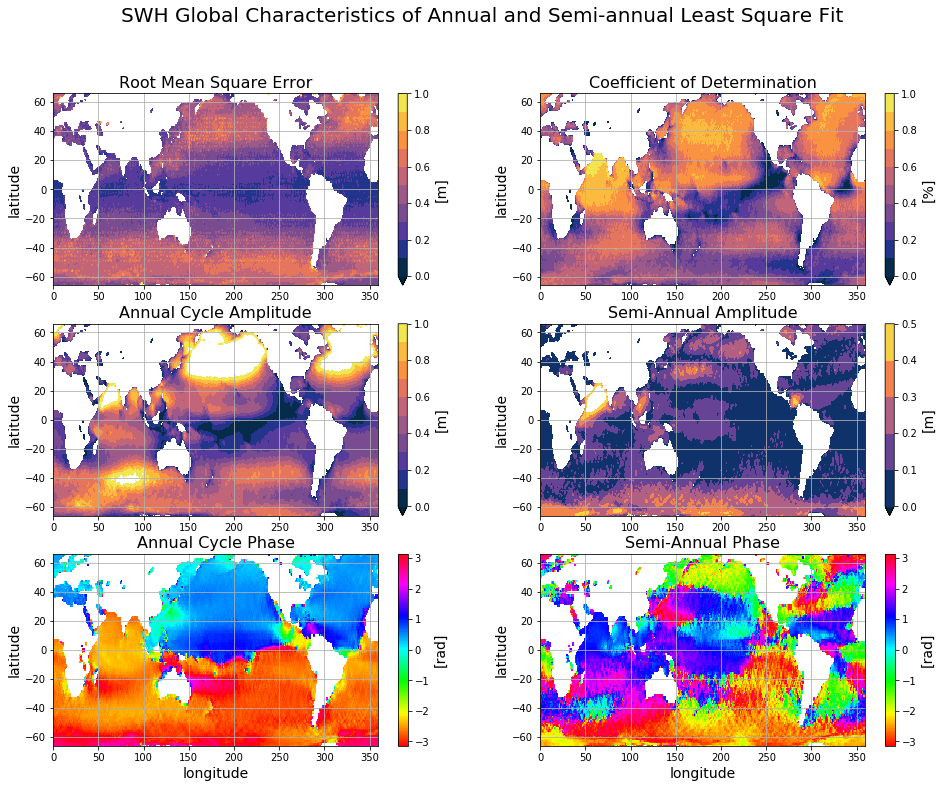

In [14]:
#initialize figure: 
fig1 = plt.figure(figsize=(16, 12))
fig1.suptitle('SWH Global Characteristics of Annual and Semi-annual Least Square Fit ', fontsize=20)

#RMS subplot: 
plt.subplot(321)

#pcolor plot: 
#plt.pcolor(lon,lat,swh_rms_m,vmin=0,vmax=0.8, cmap=cmo.thermal)

#contourf plot:
#set levels of contours
levels = np.arange(0.0, 1.1, 0.1)
plt.contourf(lon,lat,swh_rms_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Root Mean Square Error', fontsize=16)
plt.grid()

#Coefficient of Determination subplot: 
plt.subplot(322)
#plt.pcolor(lon,lat,swh_cod_m,vmin=0,vmax=1, cmap=cmo.thermal)
levels = np.arange(0.0, 1.1, 0.1)
plt.contourf(lon,lat,swh_cod_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[%]', fontsize=14)
#label figure 
plt.title('Coefficient of Determination', fontsize=16)
plt.grid()

#Annual Amplitude subplot: 
plt.subplot(323)
#plt.pcolor(lon,lat,swh_amp1_m,vmin=0,vmax=1, cmap=cmo.thermal)
levels = np.arange(0.0, 1.1, 0.1)
plt.contourf(lon,lat,swh_amp1_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Annual Cycle Amplitude', fontsize=16)
plt.grid()

#Semi-annual Amplitude subplot: 
plt.subplot(324)
#plt.pcolor(lon,lat,swh_amp2_m,vmin=0,vmax=1, cmap=cmo.thermal)
levels = np.arange(0.0, 0.6, 0.1)
plt.contourf(lon,lat,swh_amp2_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Semi-Annual Amplitude', fontsize=16)
plt.grid()

#Annual Phase subplot: 
plt.subplot(325)
plt.pcolor(lon,lat,swh_phase1_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase1_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Annual Cycle Phase', fontsize=16)
plt.grid()

#Semi-annual Phase subplot: 
plt.subplot(326)
plt.pcolor(lon,lat,swh_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Semi-Annual Phase', fontsize=16)
plt.grid()

Cartopy projection plots

In [15]:
def set_subplots_c(ax, projection, resolution, lon_min, lon_max, lat_min, lat_max):
    
    """
    set_subplots(ax, projection)
    
        Function for placing x and y axes labels for longitude and latitude respectively
        
        Parameters 
        ----------
        ax : geospatial axes for the subplot (cartopy object)
               e.g. fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
                    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten() 
        lon_min, lon_max : minimum and maximum extent for longitude on the scale from -180 to 179 
               e.g. lon_min = -180, lon_max = 179
        lat_min, lat_max : minimum and maximum extent for latitude on the scale from -90 to 89
               e.g. lat_min = -66, lat_max = 66
        
              
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
        from matplotlib import ticker
    
    """
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.coastlines(resolution=resolution)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, facecolor = 'Gray'))
    
    return

def set_cbar_c(cs, cax, fig, cbar_label, nbins, fontsize):
    
    """
    set_cbar(cs, cax, fig, cbar_label, nbins, fontsize)
    
        Function for placing x and y axes labels for longitude and latitude respectively
        
        Parameters 
        ----------
        cs : map of data on subplot axis using cartopy projection 
               e.g. cs = ax.pcolor(lon,lat,swh_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv, transform=ccrs.PlateCarree(central_longitude=0.0))
        cax : colorbar axis with positioning vector of the colorbar with the folowing parameters: 
               cax = plt.axes([left, bottom, width, height])
               e.g. cax = plt.axes([.47, .17, 0.01, 0.16])
        fig : fig with the colorbar will attached to (not refering to the subplots)
        cbar_label : colobar label in string format 
               e.g. cbar_label = '[m]'
        fontsize : font size of cbar label
               e.g. fontsize = 10
        nbins : number of tick marks on colorbar axis 
               e.g. nbins = 5
              
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
        from matplotlib import ticker
    
    """
    
    #cax, kw = matplotlib.colorbar.make_axes(ax, location='right', pad=14, shrink=0.6)
    cbar = fig.colorbar(cs, cax=cax, extend='both')
    cbar.ax.set_ylabel('%s' %cbar_label, fontsize=fontsize)
    tick_locator = ticker.MaxNLocator(nbins=nbins)
    cbar.locator = tick_locator 
    cbar.update_ticks()
    
    return

def subplot_label_c(ax, xdist_label, ydist_label, subplot_label, fs_shade, fs_main):
    
    """
    subplot_label(ax, xdist_label, ydist_label, subplot_label, fs_shade, fs_main)
    
        Function for placing subplot labels on subplots for figures that will be used in research papers 
        
        Parameters 
        ----------
        ax : geospatial axes for the subplot (cartopy object)
               e.g. fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
                    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten() 
        xdist_label : horizontal distance from plot for latitude label
               e.g. xdist_label = 0.2
        ydist_label : vertical distance for latitude label referenced from bottom of figure 
               e.g. ydist_label = 0.8
        subplot_label : string of words for label 
               e.g. subplot_label = 'A'
        fs_shade : font size of shading label
               e.g. fs_shade = 28
        fs_main : font size of main label 
               e.g. fs_main = 18
               
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
    
    
    """
    
    #ax.text(xdist_label, ydist_label, '%s' %subplot_label, va='center', ha='center',
    #    transform=ax.transAxes, fontsize=fs_shade, fontweight='bold', color='gray')
    ax.text(xdist_label, ydist_label, '%s' %subplot_label, va='center', ha='center',
        transform=ax.transAxes, fontsize=fs_main, 
        bbox = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1, alpha=.8), fontweight='bold')
    
    return

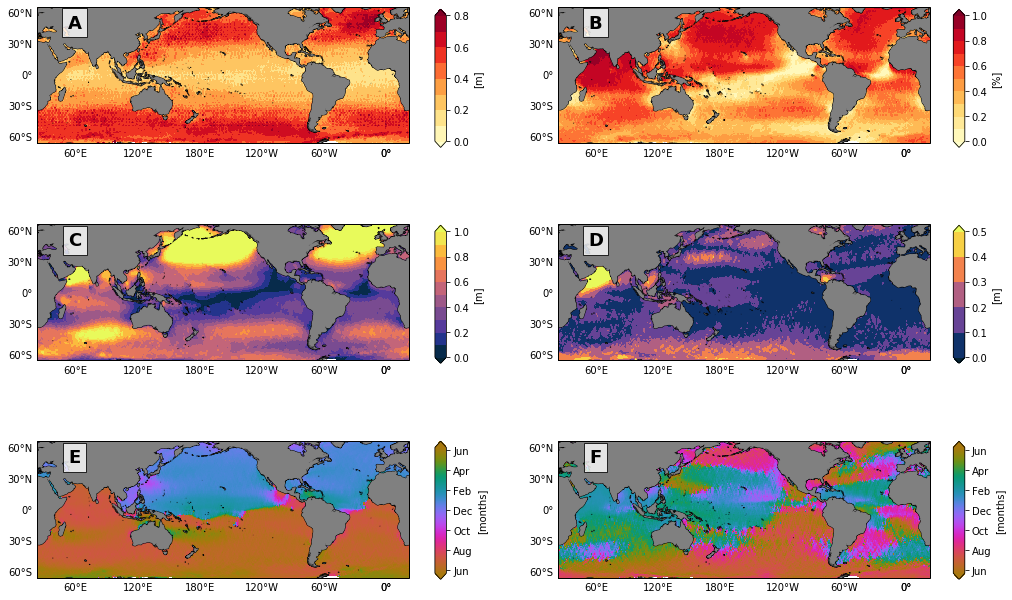

In [16]:
projection = ccrs.PlateCarree(central_longitude=-157.0)
resolution = '50m'

fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

############## Subplot 2  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 0.9, 0.1)
cs1 = ax1.contourf(lon, lat, swh_rms_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
#left, bottom, width, height
cax1 = plt.axes([.47, .67, 0.01, 0.16])
cart.set_cbar(cs1, cax1, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular' )
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs2 = ax2.contourf(lon, lat, swh_cod_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax2 = plt.axes([.92, .67, 0.01, 0.16])
cart.set_cbar(cs2, cax2, fig, orientation='vertical', cbar_label ='[%]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs3 = ax3.contourf(lon, lat, swh_amp1_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax3 = plt.axes([.47, .42, 0.01, 0.16])
cart.set_cbar(cs3, cax3, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 0.6, 0.1)
cs4 = ax4.contourf(lon, lat, swh_amp2_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax4 = plt.axes([.92, .42, 0.01, 0.16])
cart.set_cbar(cs4, cax4, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular' )
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
cart.set_subplots(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
cs5 = ax5.pcolor(lon, lat, swh_phase1_m, vmin=-np.pi, vmax=np.pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax5 = plt.axes([.47, .17, 0.01, 0.16])
cart.set_cbar(cs5, cax5, fig, orientation='vertical', cbar_label ='[months]', nbins = 7, fontsize = 10, cbar_ticks=[np.arange(-np.pi, np.pi+0.5, (np.pi + np.pi)/6).tolist(),['','Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr', 'Jun']], task='custom ticks')
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
cart.set_subplots(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
cs6 = ax6.pcolor(lon, lat, swh_phase2_m, vmin=-np.pi, vmax=np.pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax6 = plt.axes([.92, .17, 0.01, 0.16])
cart.set_cbar(cs6, cax6, fig, orientation='vertical', cbar_label ='[months]', nbins = 7, fontsize = 10, cbar_ticks=[np.arange(-np.pi, np.pi+0.5, (np.pi + np.pi)/6).tolist(),['','Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr', 'Jun']], task='custom ticks')
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.4, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/Ifremer_luke_swhcor_lsf_characteristics_5_par_fit', bbox_inches = 'tight', dpi=300)

### Plot a histogram of the annual cycle phase map (comparing my binned data phase map with bia's binned data phase map

(35843,)


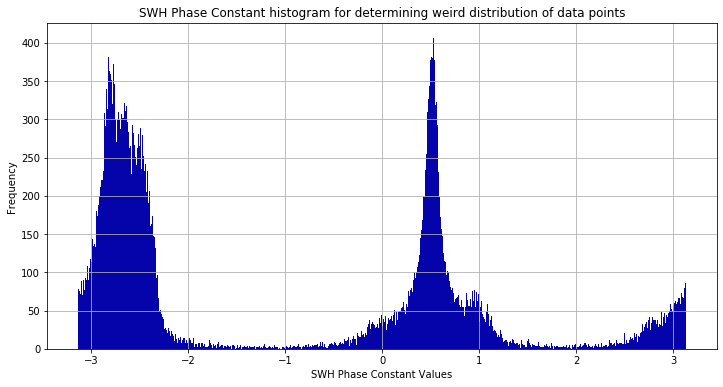

In [17]:
#flatten the swh phase constant 2D array
swh_flat = swh_phase1_m.compressed()
print(swh_flat.shape)

#plot histogram frequency of data 
plt.figure(figsize=(12,6))
plt.title('SWH Phase Constant histogram for determining weird distribution of data points')
plt.hist(swh_flat, bins=np.arange(-np.pi,np.pi,0.01), color='#0504aa', alpha=1, rwidth=1)
plt.xlabel('SWH Phase Constant Values')
plt.ylabel('Frequency')
plt.grid()


(35843,)


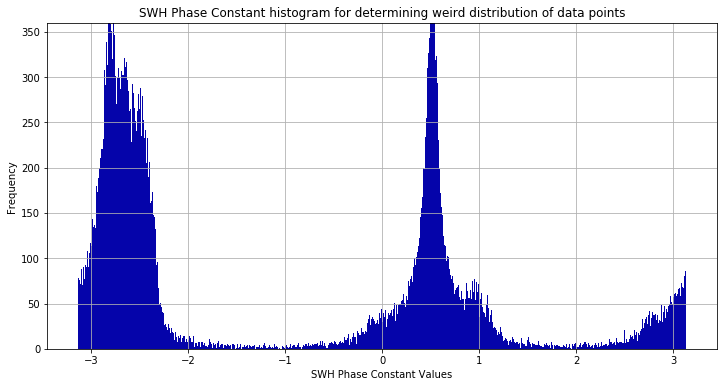

In [18]:
#flatten the swh phase constant 2D array
swh_flat = swh_phase1_m.compressed()
print(swh_flat.shape)

#plot histogram frequency of data 
plt.figure(figsize=(12,6))
plt.title('SWH Phase Constant histogram for determining weird distribution of data points')
plt.hist(swh_flat, bins=np.arange(-np.pi,np.pi,0.01), color='#0504aa', alpha=1, rwidth=1)
plt.xlabel('SWH Phase Constant Values')
plt.ylabel('Frequency')
plt.ylim([0, 360])
plt.grid()

### WSP

###### RMS, Amplitude and Phase of annual cycle, Amplitude and phase of Semi-annual cycle, Coefficient of Determination subplot figure without using Cartopy

Text(0.5, 1.0, 'Semi-Annual Phase')

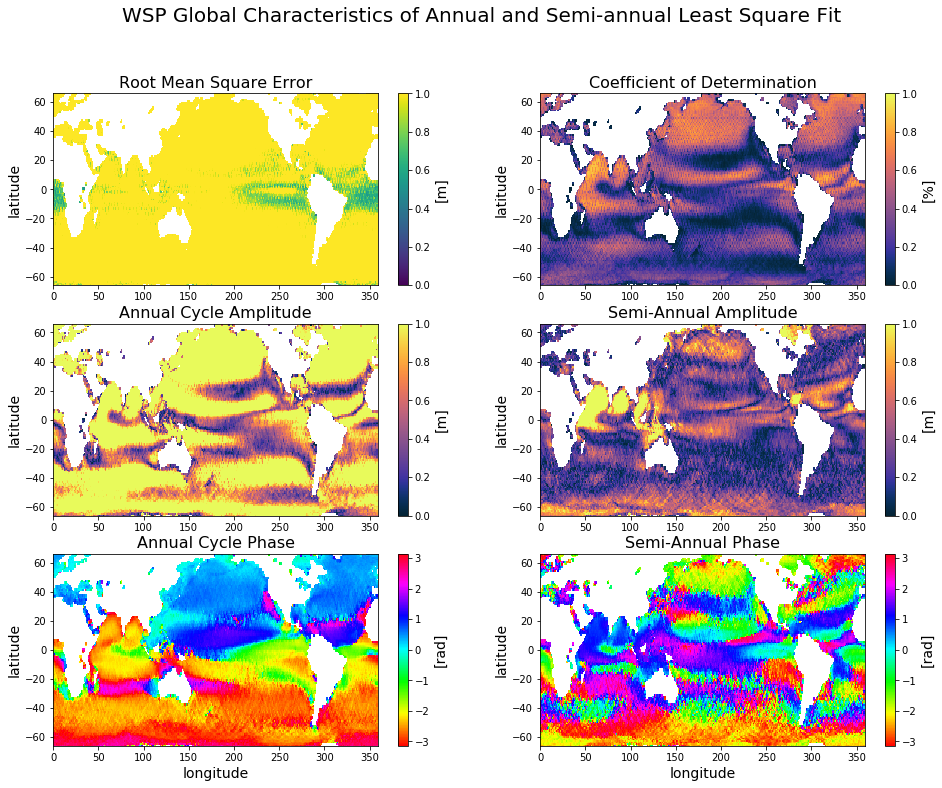

In [19]:
#initialize figure: 
fig2 = plt.figure(figsize=(16, 12))
fig2.suptitle('WSP Global Characteristics of Annual and Semi-annual Least Square Fit ', fontsize=20)

#RMS subplot: 
plt.subplot(321)
plt.pcolor(lon,lat,wsp_rms_m,vmin=0,vmax=1, cmap=cm.viridis)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Root Mean Square Error', fontsize=16)

#Coefficient of Determination subplot: 
plt.subplot(322)
plt.pcolor(lon,lat,wsp_cod_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[%]', fontsize=14)
#label figure 
plt.title('Coefficient of Determination', fontsize=16)

#Annual Amplitude subplot: 
plt.subplot(323)
plt.pcolor(lon,lat,wsp_amp1_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Annual Cycle Amplitude', fontsize=16)

#Semi-annual Amplitude subplot: 
plt.subplot(324)
plt.pcolor(lon,lat,wsp_amp2_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Semi-Annual Amplitude', fontsize=16)

#Annual Phase subplot: 
plt.subplot(325)
plt.pcolor(lon,lat,wsp_phase1_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Annual Cycle Phase', fontsize=16)

#Semi-annual Phase subplot: 
plt.subplot(326)
plt.pcolor(lon,lat,wsp_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Semi-Annual Phase', fontsize=16)

#save figure 
#plt.savefig(figname = 'wsp_lsf_characteristics_5_par_fit', bbox_inches = 'tight', dpi=300)


 Using Cartopy properly tutorial 

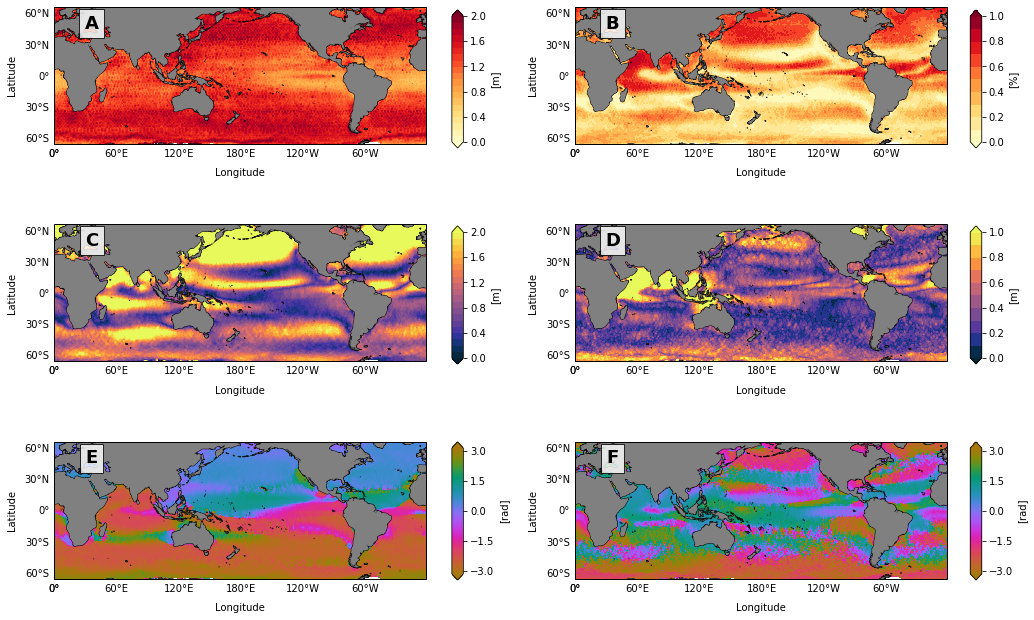

In [20]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

set_subplots_c(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs1 = ax1.contourf(lon, lat, wsp_rms_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
#left, bottom, width, height
cax1 = plt.axes([.47, .67, 0.01, 0.16])
set_cbar_c(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
set_subplots_c(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_cod_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax2 = plt.axes([.92, .67, 0.01, 0.16])
set_cbar_c(cs2, cax2, fig, cbar_label ='[%]', nbins = 5, fontsize = 10)
cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
set_subplots_c(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs3 = ax3.contourf(lon, lat, wsp_amp1_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax3 = plt.axes([.47, .42, 0.01, 0.16])
set_cbar_c(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
set_subplots_c(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 1.1, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_amp2_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax4 = plt.axes([.92, .42, 0.01, 0.16])
set_cbar_c(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
set_subplots_c(ax5, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
cs5 = ax5.pcolor(lon, lat, wsp_phase1_m, vmin=-np.pi, vmax=np.pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax5 = plt.axes([.47, .17, 0.01, 0.16])
set_cbar_c(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
set_subplots_c(ax6, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
cs6 = ax6.pcolor(lon, lat, wsp_phase2_m, vmin=-np.pi, vmax=np.pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax6 = plt.axes([.92, .17, 0.01, 0.16])
set_cbar_c(cs6, cax6, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.4, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/Ifremer_luke_wspcor_lsf_characteristics_5_par_fit', bbox_inches = 'tight', dpi=300)

### Topography and phase constant overlap for island shadowing analysis

Read in bathymetry data from server 

In [21]:
filename_bath = '/zdata/downloads/colosi_data_bk/binned_data/etopo1_bathy_data/bathymetry_topography_data/etopo1.nc'

nc_bath = Dataset(filename_bath, 'r')

#print key variables:
print(nc_bath.variables.keys())

#define variables
bathymetry = nc_bath.variables['z'][:]
lon_bath = nc_bath.variables['lon'][:]
lat_bath = nc_bath.variables['lat'][:]

odict_keys(['lon', 'lat', 'z'])


Set the extent boundaries for lon, lat and elevation

In [22]:
print(bathymetry.shape, lon_bath.shape, lat_bath.shape)
print(np.min(lon), np.max(lon), np.min(lat), np.max(lat))
print(lat_bath[3900], lat_bath[6060], lon_bath[9000], lon_bath[15600])
lat_bath = lat_bath[3900:6060]
lon_bath = lon_bath[9000:15600]
bath_m = bathymetry[3900:6060,9000:15600]
print(lon_bath.shape,lat_bath.shape, bath_m.shape)

(10801, 21601) (21601,) (10801,)
0.0 359.0 -66.0 66.0
-25.0 11.0 150.0 260.0
(6600,) (2160,) (2160, 6600)


In [23]:
bath_m = abs(bath_m)
print(bath_m.min())

0


Plot annual phase constant with topography over the central pacific ocean 

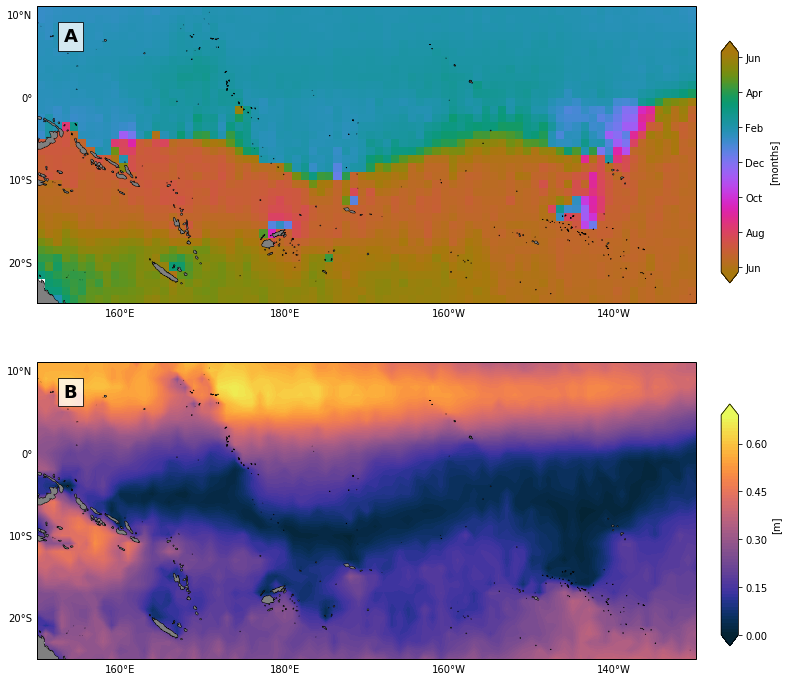

In [24]:
projection = ccrs.PlateCarree(central_longitude=180.0)

fig, axes = plt.subplots(2, 1, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2 = axes.flatten()

######## subplot 1 ########
#Annual Phase constant plot:
ax1.set_extent([-30, 50, -25, 11], projection)
ax1.coastlines(resolution='10m')
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', facecolor = 'Gray'))
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'minor_islands', '10m'))
cs1 = ax1.pcolor(lon,lat,swh_phase1_m,vmin=-pi,vmax=pi, cmap=cmo.phase, transform=ccrs.PlateCarree(central_longitude=0.0))
grd = ax1.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
grd.xlabels_top = False 
grd.ylabels_right = False 
grd.xlabel_bottom = False
grd.xlines = False
grd.ylines = False
grd.xlocator = mticker.FixedLocator([160, 180, -160, -140])
grd.ylocator = mticker.FixedLocator([-20, -10, 0, 10])
grd.xformatter = LONGITUDE_FORMATTER
grd.yformatter = LATITUDE_FORMATTER
cax1 = plt.axes([.82, .56, 0.015, 0.28])
cart.set_cbar(cs1, cax1, fig, orientation='vertical', cbar_label ='[months]', nbins = 7, fontsize = 10, cbar_ticks=[np.arange(-np.pi, np.pi+0.5, (np.pi + np.pi)/6).tolist(),['','Jun', 'Aug', 'Oct', 'Dec', 'Feb', 'Apr', 'Jun']], task='custom ticks')
cart.subplot_label(ax1, xdist_label = 0.05, ydist_label = 0.9, subplot_label = 'A', fs_shade = 28, fs_main = 18)

######## subplot 2 ########
#Annual amplitude:
ax2.set_extent([-30, 50, -25, 11], projection)
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', facecolor = 'Gray'))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'minor_islands', '10m'))
levels = np.arange(0.0, 0.7, 0.01)
cs2 = ax2.contourf(lon, lat, swh_amp1_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
grd = ax2.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
grd.xlabels_top = False 
grd.ylabels_right = False
grd.xlabel_bottom = False
grd.xlines = False
grd.ylines = False
grd.xlocator = mticker.FixedLocator([160, 180, -160, -140])
grd.ylocator = mticker.FixedLocator([-20, -10, 0, 10])
grd.xformatter = LONGITUDE_FORMATTER
grd.yformatter = LATITUDE_FORMATTER
cax2 = plt.axes([.82, .14, 0.015, 0.28])
cart.set_cbar(cs2, cax2, fig, orientation='vertical', cbar_label ='[m]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
cart.subplot_label(ax2, xdist_label = 0.05, ydist_label = 0.9, subplot_label = 'B', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/Phase_amp_topography_overlap', bbox_inches = 'tight', dpi=300)

In [25]:
# #bathymetry 
# blevels = [-8000, -7000, -6000, -5000, -4000, -3000, -2000, -1500, -1000, -500, -200, -100, 0]
# N = len(blevels)-1
# cmap = cm.Blues_r
# cmap.set_over('0.7') # light gray

# from matplotlib.colors import BoundaryNorm
# bnorm = BoundaryNorm(blevels, ncolors=N, clip=False)

# ax3.set_extent([-30, 80, -25, 11], projection)
# ax3.coastlines(resolution='10m')
# ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', facecolor = 'Gray'))
# ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'minor_islands', '10m'))

#plot bathymetry:
# cs3 = ax3.contourf(lon_bath, lat_bath, bath_m, vmin=-10000, vmax=0, levels=blevels, norm=bnorm, cmap=cmap,
#                   extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
    
# grd = ax3.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
# grd.xlabels_top = False 
# grd.ylabels_right = False 
# grd.xlines = False
# grd.ylines = False
# grd.xlocator = mticker.FixedLocator([160, 180, -160, -140, -120, -100])
# grd.ylocator = mticker.FixedLocator([-20, -10, 0, 10])
# grd.xformatter = LONGITUDE_FORMATTER
# grd.yformatter = LATITUDE_FORMATTER
# cax3 = plt.axes([.82, .13, 0.01, 0.22])

# cbar = fig.colorbar(cs3, cax=cax3, ticks=blevels[:-2]+[blevels[-1]], spacing='proportional', extend='both')
# cbar.ax.set_ylabel('[m]' , fontsize=10)
# #tick_locator = ticker.MaxNLocator(nbins=nbins)
# #cbar.locator = tick_locator 
# #cbar.update_ticks()
# ax3.text(-0.05, 0.50, 'Latitude', va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor',
#         transform=ax3.transAxes, fontsize=15)
# ax3.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
#         rotation='horizontal', rotation_mode='anchor',
#         transform=ax3.transAxes, fontsize=15)

# subplot_label_c(ax3, xdist_label = 0.06, ydist_label = 0.9, subplot_label = 'C', fs_shade = 28, fs_main = 18)


Save Ifremer swhcor characteristics arrays in a .npz file

In [26]:
np.savez('/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/char_lsf_5par_npz/ifremer_swhcor_char', swh_annual_phase = swh_phase1_m, swh_annual_amp = swh_amp1_m, swh_semi_annual_phase = swh_phase2_m, swh_semi_annual_amp = swh_amp2_m, swh_cod = swh_cod_m, swh_rms = swh_rms_m)
np.savez('/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/char_lsf_5par_npz/ifremer_swhcor', swh_monthly_mean = swh_monthly_mean, swh_monthly_std = swh_monthly_std, swh_hfit = swh_hfit_m)


Plot one time step of the Ifremer SWH data in order to illustrate the satellite tracks crossing the earth 

TypeError: set_grid_labels() missing 2 required positional arguments: 'fontsize' and 'color'

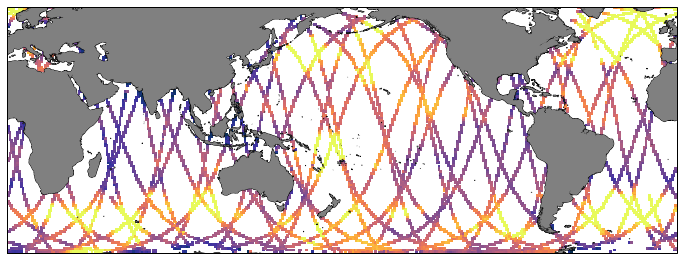

In [27]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(1, 1, figsize=(12,12),
                        subplot_kw={'projection': projection})
ax1 = axes

set_subplots_c(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
#levels = np.arange(0, 4.1, 0.1)
#cs1 = ax1.contourf(lon, lat, swh[0,:,:], levels=levels, cmap=cmo.thermal,
#                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cs1 = ax1.pcolor(lon, lat, swh[0,:,:], vmin=0, vmax=4, cmap=cmo.thermal, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.92, .4, 0.01, 0.2])
set_cbar_c(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/satellite_tracks/satellite_tracks_93', bbox_inches = 'tight', dpi=300)


### Development code: 

In [ ]:
#check all the variable currently defined
%who
#look at swh_month_mean and wsp_month_mean
print(swh_month_mean)
print(swh_month_mean['time'][:])

In [ ]:
#A = np.fill((5,8766),8)
A = np.zeros((8766,5)) 
data = np.sin(np.arange(1,8766+1,1))
time = np.arange(1,len(data)+1,1)
print(A)
A[:,0] = 1.0
A[:,1] = time
A[:,2] = np.sin(time*2*np.pi/365.25)
A[:,3] = np.cos(time*2*np.pi/365.25)
print(A)
A_1 = A.T@A
print(A_1.shape)
A_2 = np.linalg.inv(A_1)
A_3 = A_2@A.T
print(A_3.shape)

##### Test monthly_average function: 

In [ ]:
#import necessary libraries: 
import datetime
#numpy is already imported 

#set variables inputted into function: 
data = swh
date_time = time_i

#begin debugging line by line: 
assert isinstance(date_time, np.ndarray), 'date_time should be an array'
#assertion is satisfied

#set year and month indices that correspond swh
years = np.array([y.year for y in date_time])
months = np.array([m.month for m in date_time])

#establish dictionary 
monthly_data = {}
monthly_data = {'time': [], 'mean': [], 'median': [],'std': [],'N': [] }

#no errors yet!!

#Pick a year and month: 
year = 1993
month = 1

#establish a boolean matrix for indices of time steps that have data collected from this year and month: 
ind_year = years == year 
ind_month = months == month
ind = ind_year*ind_month

#apply indice to swh and time arrays and calculate mean, std, median, and nobs using a try block (the try block will run a  block of code until an error occurs or the block of code is complete. If an error occurs, the code stops and is transfered down to the except block:
try:
    tmp = data[ind]
    time = date_time[ind]
    delta_t = datetime.timedelta(seconds=np.mean([(t-time[0]).total_seconds() for t in time]))
    monthly_data['time'].append(time[0] + delta_t)
    monthly_data['mean'].append(np.nanmean(tmp, axis=0))
    monthly_data['median'].append(np.nanmedian(tmp, axis=0))
    monthly_data['std'].append(np.nanstd(tmp, axis=0))
    monthly_data['N'].append(np.size(tmp[~np.isnan(tmp)]))
except: print(year)

#if no errors occured, check result of mean:     
#print(monthly_data['mean'])

#see if all the values in the matrix are nan: 
inan = np.isnan(monthly_data['mean'])
#print(inan)

#so with the current monthly_average function, the entire mean is nan at each grid point
#I will try to change the np.ma.mean (takes the mean whie ignoring masked values) to np.nanmean (takes the mean while ignoring nan values)

#I believe it worked!!!

#check what tmp.compress does: 
#print(tmp.compressed())
#compressed returns all the non-masked data as a 1-D array

##### Test Least square fit function: 

In [ ]:
#import necessary libraries: 
import numpy as np
from scipy.linalg import inv

#set ilat and ilon
ilat, ilon =  0, 49

#call data in monthly mean matrix for swh and wsp: 
swh_grid = swh_monthly_mean[:,ilat,ilon]
wsp_grid = wsp_monthly_mean[:,ilat,ilon]

#data has the correct shape of 288 monthly mean time steps 
#print(swh_grid.shape, wsp_grid.shape)

#set variables: 
data = swh_grid
parameters = 5 
period = 12

print(data)

#find where the data is NaN and exclude these values from the least square fit: 
ind = ~np.isnan(data)
data_c = data[ind]

#Check that NaN values are excluded:
data_f = data[np.isnan(data)]
print(data_c.shape, data_f.shape, 136 + 152)
#it looks good!

#initialize time vector: 
time = np.arange(1,len(data_c)+1,1)
print(time.shape)

#set number of parameters and length of data: 
N, M = parameters, len(data_c)

print(N,M)

#create model matrix: 
A = np.zeros((M,N))

#place parameters in model matrix:
A[:,0] = 1.0
A[:,1] = np.sin(time*2*np.pi/period)
A[:,2] = np.cos(time*2*np.pi/period)
A[:,3] = np.sin(time*2*np.pi/(period/2))
A[:,4] = np.cos(time*2*np.pi/(period/2))

#check if A is correctly formatted 
print(A.shape)

#Compute solution to the matrix equation Ax = b:
x_data = inv(A.T @ A) @ A.T @ data_c

print(x_data)

##### Test Characteristics of least square fit function: 

In [ ]:
print(ilat,ilon)

In [ ]:
A = np.ma.array([1,2,3,np.nan])
print(A)
print(A[~np.isnan(A)])
print(np.size(A.compressed()))

In [ ]:
t_1 = np.arange(0,nlon,1)
t_2 = np.zeros((1,nlon))
print(type(t_1),type(t_2[0]))

In [ ]:
x_ticks = np.arange(0,360,50)
print(x_ticks)
y_ticks = np.arange(-60,80,20)
print(y_ticks)

In [ ]:
grdl.xlabels_top?

In [ ]:
#create figure and establish ax for projection
fig = plt.figure(figsize=(16,14))
#set spacing between subplots 
wspace = 0.2
hspace = 0.4

#RMS subplot:
#set the axis to a subplot location with the projection plateCarree
ax2 = plt.subplot(321, projection=ccrs.PlateCarree(central_longitude=180.0))
#set the extent of the map using the same projection (note that the extent is centered around england and the format is: set_extent([lon_min, lon_max, lat_min, lat_max]))
ax2.set_extent([-180, 179, -66, 66], ccrs.PlateCarree(180.0))
#plt.subplots_adjust(top=0.95, bottom=0.08, left=0.10, right=0.95, wspace = wspace,hspace = hspace)
#set coastlines and land features on the plot 
ax2.coastlines()
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#Plot data
#fi2 = ax2.pcolor(lon,lat,swh_rms_m,vmin=0,vmax=1.0, cmap=cmo.thermal, transform=ccrs.PlateCarree())
levels = np.arange(0.0, 0.9, 0.1)
fi2 = ax2.contourf(lon,lat,swh_rms_m,levels=levels,cmap=cmo.thermal,extend='both',transform=ccrs.PlateCarree())
#set x and y tick mark using the gridline class which places gridlines on the plot which has ticks labels on each gridline on all four sides of the plot
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#take the tick labels off the top and right side of the plot 
gl2.xlabels_top = False
gl2.ylabels_right = False
#remove grid lines from plot 
gl2.xlines = False
gl2.ylines = False
#set the location of the x and y tick marks on the plot 
gl2.xlocator = mticker.FixedLocator([5, 45, 90, 135, 180, -135, -90, -45, -5])
gl2.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
#place compass labels on all of the x and y ticks
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
#set the colorbar 
cax,kw = matplotlib.colorbar.make_axes(ax2,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(fi2,cax=cax,extend='both',**kw)
out.ax.set_ylabel('[m]')
#label axices of figure and place title
ax2.set_title('Root Mean Square Error', fontsize=15)
ax2.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax2.transAxes, fontsize=10)
ax2.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax2.transAxes, fontsize=10)

#Coefficient of determination subplot:
ax3 = plt.subplot(322, projection=ccrs.PlateCarree(central_longitude=180.0))
ax3.set_extent([-180, 179, -66, 66], ccrs.PlateCarree(180.0))
#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, wspace = wspace, hspace = hspace)
ax3.coastlines()
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#set coastlines and land features on the plot 
ax3.coastlines()
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#Plot data
#fi3 = ax3.pcolor(lon,lat,swh_cod_m,vmin=0,vmax=1.0, cmap=cmo.thermal, transform=ccrs.PlateCarree())
levels = np.arange(0.0, 1.1, 0.1)
fi3 = ax3.contourf(lon,lat,swh_cod_m,levels=levels,cmap=cmo.thermal,extend='both',transform=ccrs.PlateCarree())
#set x and y tick mark using the gridline class which places gridlines on the plot which has ticks labels on each gridline on all four sides of the plot
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#take the tick labels off the top and right side of the plot 
gl3.xlabels_top = False
gl3.ylabels_right = False
#remove grid lines from plot 
gl3.xlines = False
gl3.ylines = False
#set the location of the x and y tick marks on the plot 
gl3.xlocator = mticker.FixedLocator([5, 45, 90, 135, 180, -135, -90, -45, -5])
gl3.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
#place compass labels on all of the x and y ticks
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER
#set the colorbar 
cax,kw = matplotlib.colorbar.make_axes(ax3,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(fi3,cax=cax,extend='both',**kw)
out.ax.set_ylabel('[%]')
#label axices of figure and place title
ax3.set_title('Coefficient of Determination', fontsize=15)
ax3.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax3.transAxes, fontsize=10)
ax3.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax3.transAxes, fontsize=10)

#Annual Amplitude subplot:
ax4 = plt.subplot(323, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4.set_extent([-180, 179, -66, 66], ccrs.PlateCarree(180.0))
#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, wspace = wspace, hspace = hspace)
ax4.coastlines()
ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#Plot data
#fi4 = ax4.pcolor(lon,lat,swh_amp1_m,vmin=0,vmax=1.0, cmap=cmo.thermal, transform=ccrs.PlateCarree())
levels = np.arange(0.0, 1.3, 0.1)
fi4 = ax4.contourf(lon,lat,swh_amp1_m,levels=levels,cmap=cmo.thermal,extend='both',transform=ccrs.PlateCarree())
#set x and y tick mark using the gridline class which places gridlines on the plot which has ticks labels on each gridline on all four sides of the plot
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#take the tick labels off the top and right side of the plot 
gl4.xlabels_top = False
gl4.ylabels_right = False
#remove grid lines from plot 
gl4.xlines = False
gl4.ylines = False
#set the location of the x and y tick marks on the plot 
gl4.xlocator = mticker.FixedLocator([5, 45, 90, 135, 180, -135, -90, -45, -5])
gl4.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
#place compass labels on all of the x and y ticks
gl4.xformatter = LONGITUDE_FORMATTER
gl4.yformatter = LATITUDE_FORMATTER
#set the colorbar 
cax,kw = matplotlib.colorbar.make_axes(ax4,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(fi4,cax=cax,extend='both',**kw)
out.ax.set_ylabel('[m]')
#label axices of figure and place title
ax4.set_title('Annual Cycle Amplitude', fontsize=15)
ax4.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax4.transAxes, fontsize=10)
ax4.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax4.transAxes, fontsize=10)

#Semi-annual Amplitude subplot: 
ax5 = plt.subplot(324, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5.set_extent([-180, 179, -66, 66], ccrs.PlateCarree(180.0))
#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, wspace = wspace, hspace = hspace)
ax5.coastlines()
ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#Plot data
#fi5 = ax5.pcolor(lon,lat,swh_amp2_m,vmin=0,vmax=1.0, cmap=cmo.thermal, transform=ccrs.PlateCarree())
levels = np.arange(0.0, 0.6, 0.1)
fi5= ax5.contourf(lon,lat,swh_amp2_m,levels=levels,cmap=cmo.thermal,extend='both',transform=ccrs.PlateCarree())
#set x and y tick mark using the gridline class which places gridlines on the plot which has ticks labels on each gridline on all four sides of the plot
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#take the tick labels off the top and right side of the plot 
gl5.xlabels_top = False
gl5.ylabels_right = False
#remove grid lines from plot 
gl5.xlines = False
gl5.ylines = False
#set the location of the x and y tick marks on the plot 
gl5.xlocator = mticker.FixedLocator([5, 45, 90, 135, 180, -135, -90, -45, -5])
gl5.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
#place compass labels on all of the x and y ticks
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER
#set the colorbar 
cax,kw = matplotlib.colorbar.make_axes(ax5,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(fi5,cax=cax,extend='both',**kw)
out.ax.set_ylabel('[m]')
#label axices of figure and place title
ax5.set_title('Semi-annual Cycle Amplitude', fontsize=15)
ax5.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax5.transAxes, fontsize=10)
ax5.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax5.transAxes, fontsize=10)

#annual Phase subplot: 
ax5 = plt.subplot(325, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5.set_extent([-180, 179, -66, 66], ccrs.PlateCarree(180.0))
#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, wspace = wspace, hspace = hspace)
ax5.coastlines()
ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#Plot data
fi5 = ax5.pcolor(lon,lat,swh_phase1_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv, transform=ccrs.PlateCarree())
#levels = np.arange(0.0, 1.1, 0.1)
#fi5= ax5.contourf(lon,lat,swh_phase1_m,levels=levels,cmap=cmo.thermal,extend='both',transform=ccrs.PlateCarree())
#set x and y tick mark using the gridline class which places gridlines on the plot which has ticks labels on each gridline on all four sides of the plot
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#take the tick labels off the top and right side of the plot 
gl5.xlabels_top = False
gl5.ylabels_right = False
#remove grid lines from plot 
gl5.xlines = False
gl5.ylines = False
#set the location of the x and y tick marks on the plot 
gl5.xlocator = mticker.FixedLocator([5, 45, 90, 135, 180, -135, -90, -45, -5])
gl5.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
#place compass labels on all of the x and y ticks
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER
#set the colorbar 
cax,kw = matplotlib.colorbar.make_axes(ax5,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(fi5,cax=cax,extend='both',**kw)
out.ax.set_ylabel('[rad]')
#label axices of figure and place title
ax5.set_title('Annual Cycle Phase Constant', fontsize=15)
ax5.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax5.transAxes, fontsize=10)
ax5.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax5.transAxes, fontsize=10)

#Semi-annual phase subplot: 
ax5 = plt.subplot(326, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5.set_extent([-180, 179, -66, 66], ccrs.PlateCarree(180.0))
#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, wspace = wspace, hspace = hspace)
ax5.coastlines()
ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#Plot data
fi5 = ax5.pcolor(lon,lat,swh_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv, transform=ccrs.PlateCarree())
#levels = np.arange(0.0, 1.1, 0.1)
#fi5= ax5.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cmo.thermal,extend='both',transform=ccrs.PlateCarree())
#set x and y tick mark using the gridline class which places gridlines on the plot which has ticks labels on each gridline on all four sides of the plot
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#take the tick labels off the top and right side of the plot 
gl5.xlabels_top = False
gl5.ylabels_right = False
#remove grid lines from plot 
gl5.xlines = False
gl5.ylines = False
#set the location of the x and y tick marks on the plot 
gl5.xlocator = mticker.FixedLocator([5, 45, 90, 135, 180, -135, -90, -45, -5])
gl5.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
#place compass labels on all of the x and y ticks
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER
#set the colorbar 
cax,kw = matplotlib.colorbar.make_axes(ax5,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(fi5,cax=cax,extend='both',**kw)
out.ax.set_ylabel('[rad]')
#label axices of figure and place title
ax5.set_title('Semi-annual Cycle Phase Constant', fontsize=15)
ax5.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax5.transAxes, fontsize=10)
ax5.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax5.transAxes, fontsize=10)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/Ifremer_swhcor_lsf_characteristics_5_par_fit', bbox_inches = 'tight', dpi=300)

In [ ]:
#left, bottom, width, height
ax1.axes([0.1, 0.1, 0.4, 0.02])

In [ ]:
#set the figure and the subplots 
fig = plt.figure(figsize=(16,12))

#Annual Phase constant plot:
#set the axis to a subplot location with the projection plateCarree
ax2 = plt.subplot(321, projection=ccrs.PlateCarree(central_longitude=180.0))
#set the extent of the map using the same projection (note that the extent is centered around england and the format is: set_extent([lon_min, lon_max, lat_min, lat_max]))
ax2.set_extent([-180, 179, -66, 66], ccrs.PlateCarree(180.0))
#set coastlines and land features on the plot 
ax2.coastlines()
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#Plot data using contourf (set level sets for contour)
levels = np.arange(0.0, 1.1, 0.1)
fi2 = ax2.contourf(lon,lat,swh_rms_m,levels=levels,cmap=cmo.thermal,extend='both',transform=ccrs.PlateCarree())
#set x and y tick mark using the gridline class which places gridlines on the plot which has ticks labels on each gridline on all four sides of the plot
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#take the tick labels off the top and right side of the plot 
gl2.xlabels_top = False
gl2.ylabels_right = False
#remove grid lines from plot 
gl2.xlines = False
gl2.ylines = False
#set the location of the x and y tick marks on the plot 
gl2.xlocator = mticker.FixedLocator([5, 45, 90, 135, 180, -135, -90, -45, -5])
gl2.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
#place compass labels on all of the x and y ticks
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
#set the colorbar 
cax,kw = matplotlib.colorbar.make_axes(ax2,location='right',pad=0.05,shrink=0.6)
out=fig.colorbar(fi2,cax=cax,extend='both',**kw)
out.ax.set_ylabel('[m]')
#label axices of figure and place title
ax2.set_title('Root Mean Square Error', fontsize=15)
ax2.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax2.transAxes, fontsize=10)
ax2.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax2.transAxes, fontsize=10)

#Coefficent of determination subplot:
#ax2 = plt.subplot(3, 2, 2, projection=ccrs.PlateCarree(central_longitude=180.0))
#ax2.set_extent([0, 360, -66, 66], ccrs.PlateCarree())
#ax2.pcolor(lon,lat,swh_cod_m,vmin=0,vmax=1.0, cmap=cm.Blues, transform=ccrs.PlateCarree())
#ax2.coastlines()
#ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor = 'Gray'))
#gl = ax1.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
#gl.xlabels_top = False
#gl.ylabels_right = False
#gl.xlines = False
#gl.ylines = False
#gl.xlocator = mticker.FixedLocator([0, 50, 100, 150, 200, 250, 300, 350])
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#set colorbar
#plt.colorbar(ax=ax2)
#label colorbar and set font
#cbar.set_label('[m]', fontsize=14)
#label figure 
#plt.title('Coefficient of Determination', fontsize=16)
#ax2.set_xlabel("Longitude", fontsize=14)
#ax2.set_ylabel("Latitude", fontsize=14)
#plt.tight_layout()

In [ ]:
#plot: 

plt.pcolor(lon,lat,wsp_c[8,:,:],vmin=0,vmax=6, cmap=cm.viridis)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Check binning of WW3 Hs', fontsize=16)


In [ ]:
print()

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

swh_test = swh_c[:,9,20]
print(swh_test)
plt.plot(np.arange(nt), swh_test, 'b-')
ind_test = swh_test.mask

print((ind_test))

In [ ]:
swh_amp1_m.shape

In [ ]:
print(swh.shape, swh_c.shape, time_i.shape, time_c.shape)
print(time_c[0])
print(np.ma.array(swh_month_data['mean']).shape)

In [ ]:
#plot: 
plt.pcolor(lon, lat,swh_c[0,:,:])


In [ ]:
#plot: 
plt.pcolor(lon, lat,swh_c[1,:,:])

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
print(ind_time.shape)

In [ ]:
swh_c = np.compress(ind_time, swh, axis = 0)

In [ ]:
%whos

In [ ]:
#bathymetry 
ax3.set_extent([-30, 80, -25, 11], projection)
ax3.coastlines(resolution='10m')
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', facecolor = 'Gray'))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'minor_islands', '10m'))
#plot bathymetry:
cmap = plt.get_cmap('Blues')
norm = matplotlib.colors.Normalize(0, 6000)
for letter, level in [
                      ('L', 0),
                      ('K', 200),
                      ('J', 1000),
                      ('I', 2000),
                      ('H', 3000),
                      ('G', 4000),
                      ('F', 5000),
                      ('E', 6000)]:
                      #('D', 7000),
                      #('C', 8000),
                      #('B', 9000),
                      #('A', 10000)]:
    bathym = cfeature.NaturalEarthFeature(name='bathymetry_{}_{}'.format(letter, level),
                                 scale='10m', category='physical')
    bath = ax3.add_feature(bathym, facecolor=cmap(norm(level)), edgecolor='face')
    
grd = ax3.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=2, color='gray', alpha=0, linestyle='--')
grd.xlabels_top = False 
grd.ylabels_right = False 
grd.xlines = False
grd.ylines = False
grd.xlocator = mticker.FixedLocator([160, 180, -160, -140, -120, -100])
grd.ylocator = mticker.FixedLocator([-20, -10, 0, 10])
grd.xformatter = LONGITUDE_FORMATTER
grd.yformatter = LATITUDE_FORMATTER
cax3 = plt.axes([.78, .13, 0.01, 0.30])
cbar3 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=cax3, extend='both')
#cbar3.ax.set_ylabel('[m]', fontsize=10)
#tick_locator = ticker.MaxNLocator(nbins=5)
#cbar3.locator = tick_locator 
#cbar3.update_ticks()
ax3.text(-0.05, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax3.transAxes, fontsize=15)
ax3.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax3.transAxes, fontsize=15)

subplot_label_c(ax3, xdist_label = 0.06, ydist_label = 0.9, subplot_label = 'C', fs_shade = 28, fs_main = 18)


In [ ]:
np.max(swh_hfit_m)

In [ ]:
%reset

In [ ]:
import numpy as np
print(range(0,360+1))

In [ ]:

for ilon in range(0,133):
    print(ilon)
        